### Preliminars

##### Imports

In [1]:
import preprocess
import sample
import cluster
import nn
import k_means
import fuzzy_c_means
import mountain
import regression
import visualize

import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
import os

%matplotlib widget
%reload_ext autoreload
%autoreload 2

np.random.seed(420)
x_size, y_size = 4, 4
def fig_size(y, x): return (x*x_size, y*y_size)
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

os.chdir("../images/")


##### Read Data

In [2]:
dataset = 0
if dataset == 0:
    csv_file = "../data/pulsar_data_train.csv"
    csv_index, csv_header = None, 0
    csv_out = -1
    classify = True
elif dataset == 1:
    csv_file = "../data/IRIS.csv"
    csv_index, csv_header = 0, 0
    csv_out = -1
    classify = True
else:
    csv_file = '../data/examen.csv'
    csv_index, csv_header = None, None
    csv_out = -1
    classify = False

data, N_S, I_S = preprocess.get_data(csv_file, csv_header, csv_index)
X_S, Y_S, X_name, Y_name = preprocess.split_XY(data, csv_out)
X_S, Y_S, X_revert, Y_revert = preprocess.preprocess(X_S.T, Y_S.T, classify)

In [3]:
Y_S

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Sample

### PDF properties

In [4]:
pdf_info = sample.pdf_info(I_S)


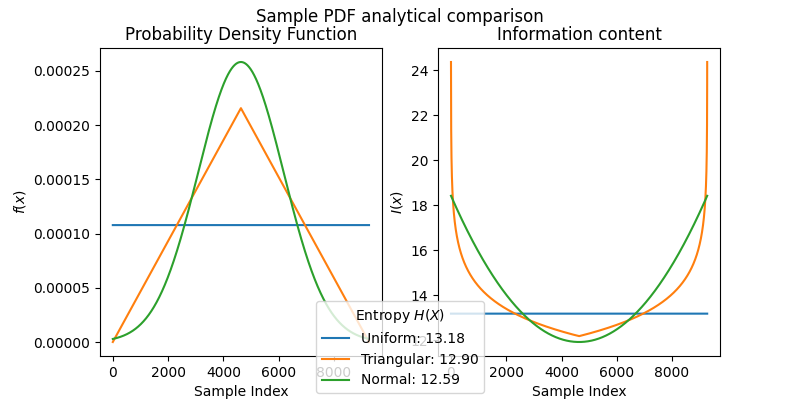

In [5]:
fig, ax = plt.subplots(1, 2, figsize=fig_size(1, 2))
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(I_S, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(I_S, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")
fig.savefig("sample:info")


### Sampling data

In [6]:
pdf_sample = sample.sample(I_S)
partition_i = pdf_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in partition_i.items()}


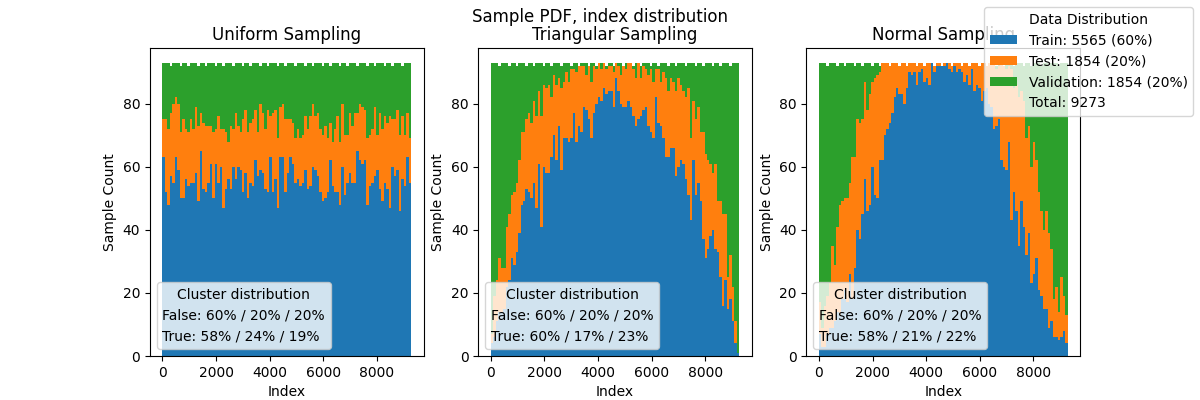

In [7]:
#Figure title
fig, ax = plt.subplots(1, 3, figsize=fig_size(1, 3))
fig.suptitle("Sample PDF, index distribution")
for ax_i, (pdf_name, pdf_partition) in zip(ax, pdf_sample.items()):
    ax_i.set_title(f"{pdf_name} Sampling")
    cluster.axis_labels(ax_i, 'Index', 'Sample Count')
    ax_i.hist(pdf_partition.values(), stacked=True, bins=100)
    if not cluster:
        continue
    legend = []

    for c in range(len(Y_revert)):
        legend_temp = []
        for partition_name, partition_index in pdf_partition.items():
            legend_temp.append(f"{np.sum(Y_S[c, partition_index])/np.sum(Y_S[c,:] == 1):.0%}")
        legend.append(f"{Y_revert[c]}: " + " / ".join(legend_temp))

    legend = ax_i.legend(legend, title="Cluster distribution", loc="lower left", handlelength=0, handletextpad=0)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                     for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig("sample:hist:index")


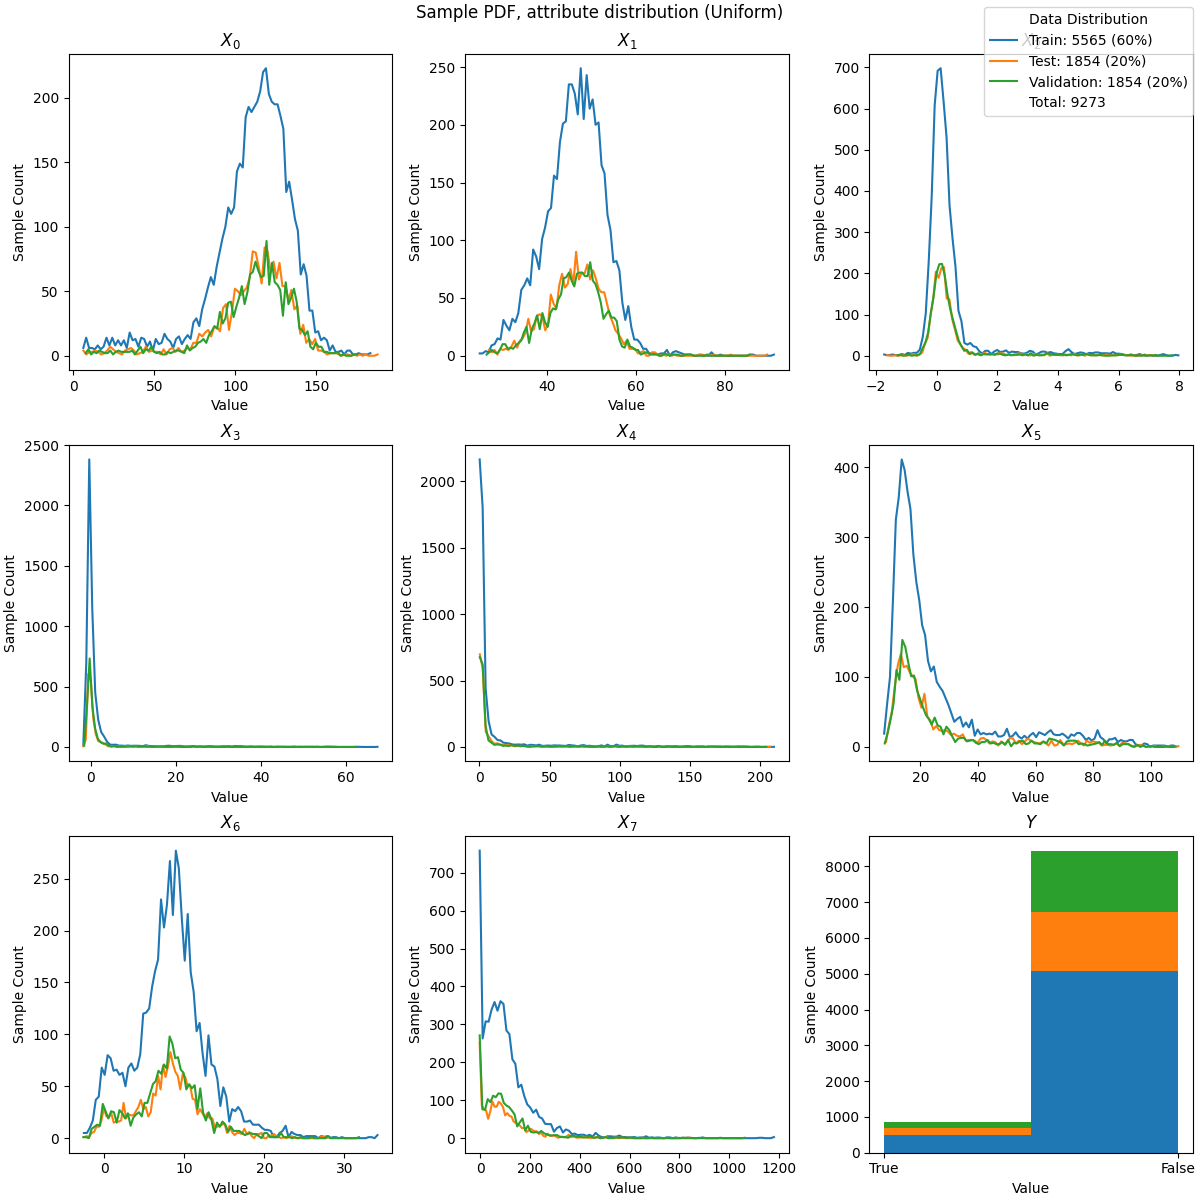

In [8]:
    
fig, ax = plt.subplots(3, 3, figsize=fig_size(3, 3), constrained_layout = True)
fig.suptitle(f"Sample PDF, attribute distribution (Uniform)")
for i in range(len(X_name)):
    ax_i = ax.flatten()[i]
    ax_i.set_title(f"$X_{i}$")
    cluster.axis_labels(ax_i, 'Value', 'Sample Count')
    for p in partition.values():
        yh, xh = np.histogram(X_revert(p[0])[i, :], bins=100)
        ax_i.plot(xh[:-1], yh)
i = 8
ax_i = ax.flatten()[i]
ax_i.set_title(f"$Y$")
cluster.axis_labels(ax_i, 'Value', 'Sample Count')
ax_i.hist([list(map(lambda x: Y_revert[x], np.argmax(p[1], axis=0))) for p in partition.values()], stacked=True, bins=2)
legend = fig.legend([f"{k}: {len(v)} ({len(v)/N_S:.0%})"
                    for k, v in partition_i.items()] + [f"Total: {N_S}"],
                    title="Data Distribution", loc="upper right")
legend.legendHandles[-1].set_visible(False)
fig.savefig("sample:hist:attributes")

### Data Distribution

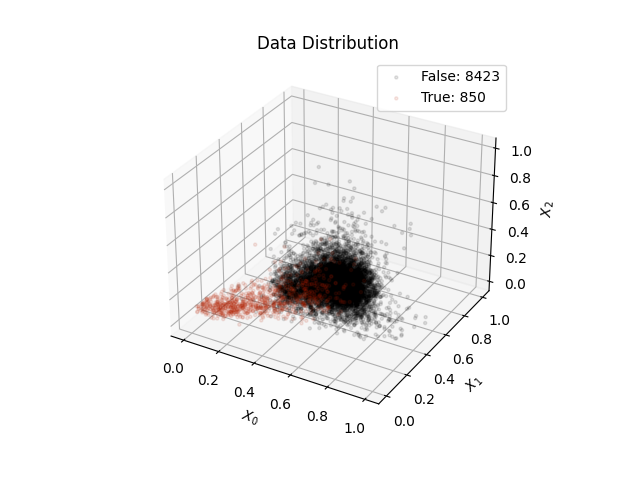

In [20]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
visualize.cluster(ax, X_S[[0,1,6], :], Y_S, title="Data Distribution", cluster_names=Y_revert, fuzzy=False)
fig.savefig("sample:dist:train.png")

# Supervised Learning

### Linear Regression

In [10]:
B_linear, E_linear = regression.linear(*partition["Train"])
B_logistic, E_logistic = regression.logistic(*partition["Train"])


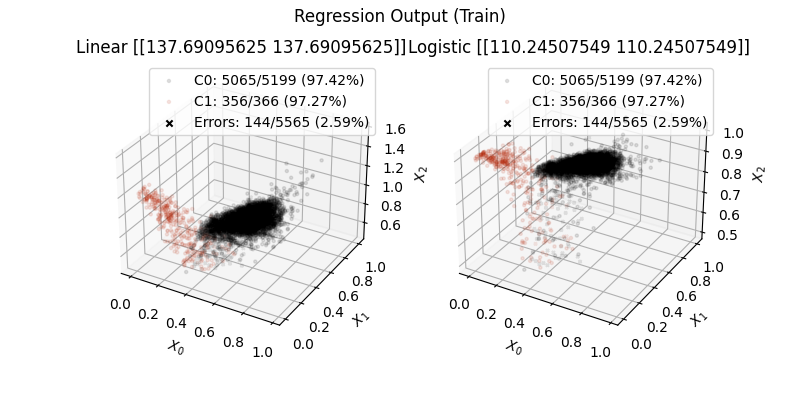

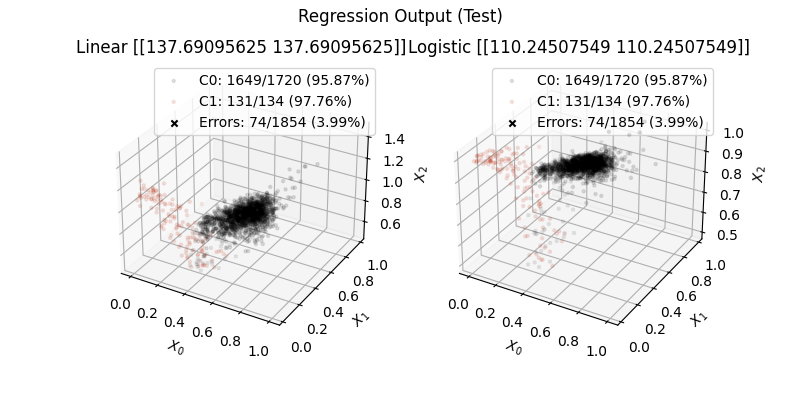

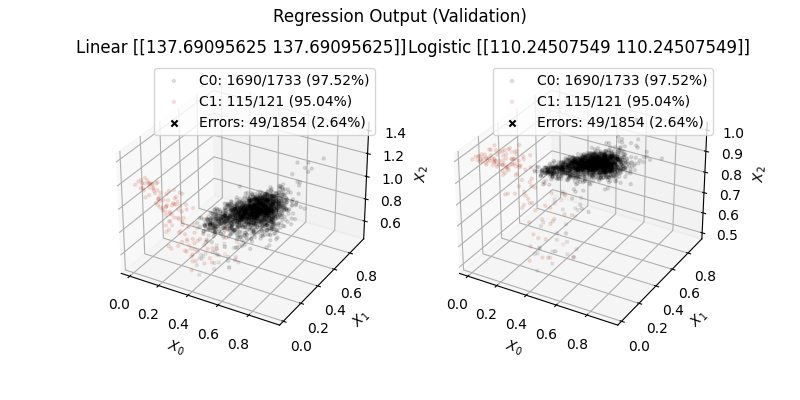

In [31]:
def compare(U, Ud):
    return np.any(U == Ud, axis=0)

for name, (X, Y) in partition.items():
    # create fig and subplots
    fig, ax = plt.subplots(1, 2, figsize=fig_size(
        1, 2), subplot_kw={'projection': '3d'})
    fig.suptitle(f"Regression Output ({name})")
    U = regression.linear_eval(X, B_linear)
    visualize.cluster(ax[0], X, U, Ud=Y, fuzzy=True, title=f"Linear {E_linear}")

    U = regression.logistic_eval(X, B_logistic)
    visualize.cluster(ax[1], X, U, Ud=Y, fuzzy=True, title=f"Logistic {E_logistic}")


### Neural Network

In [12]:
epochs = 1000
neurons = np.array(range(5))+1
layers = np.array(range(3))+1
eta = [0.2, 0.5, 0.9]

nn_metric = {
    "grad:min": (np.inf, None, None), 
    "grad:max": (-np.inf, None, None),
    "err:min" : (np.inf, None, None),
    "err:max" : (-np.inf, None, None)
}

for params in iter.product(neurons, layers, eta):   
    c_neurons, c_layers, c_eta = params
    print(params)
    with HiddenPrints():
        W, B, delta_nn, E_nn = nn.train(partition["Train"], epochs=epochs, 
            hidden=[c_neurons] * c_layers, eta=c_eta, classify=classify, test_set=partition)
    grad = np.sum(delta_nn[-1])
    err = np.sum([e[-1] for e in E_nn.values()])

    if grad < nn_metric["grad:min"][0]:
        nn_metric["grad:min"] = (grad, params, (W, B, delta_nn, E_nn))
    elif grad > nn_metric["grad:max"][0]:
        nn_metric["grad:max"] = (grad, params, (W, B, delta_nn, E_nn))
    if err < nn_metric["err:min"][0]:
        nn_metric["err:min"] = (err, params, (W, B, delta_nn, E_nn))
    elif err > nn_metric["err:max"][0]:
        nn_metric["err:max"] = (err, params, (W, B, delta_nn, E_nn))

(1, 1, 0.2)


KeyboardInterrupt: 

In [ ]:
skip = 10
nn_title = {
    "grad:min": "Min Gradient",
    "grad:max": "Max Gradient",
    "err:min": "Min Error",
    "err:max": "Max Error"
}
for name, (value, (neurons, layers, eta), ((W, B, delta_nn, E_nn))) in nn_metric.items():
    fig, ax = plt.subplots(1, 2, figsize=fig_size(1, 2))
    fig.suptitle(f"{nn_title[name]}: {neurons, layers, eta}")
    ax[0].set_title("Gradients per epoch")
    ax[0].plot(range(skip, epochs), delta_nn[skip:],
            label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
    ax[0].plot([], [], label = f"Total: {np.sum(delta_nn[-1]):.2e}")
    legend = ax[0].legend(title="Layer", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[0], "Epoch",
                        "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

    ax[1].set_title("Error per epoch")
    for p_name in E_nn.keys():
        ax[1].plot(range(skip, epochs), E_nn[p_name][skip:],
                label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
    ax[1].plot([], [], label = f"Total: {np.sum([e[-1] for e in E_nn.values()]):.2e}")
    legend = ax[1].legend(title="Partition", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[1], "Epoch",
                        "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")
    fig.savefig(f"nn:{name}.png")

In [ ]:
for name, (value, (neurons, layers, eta), (W, B, delta_nn, E_nn)) in nn_metric.items():
    print(name)
    with HiddenPrints():
        W, B, delta_nn2, E_nn2 = nn.train(partition["Train"], epochs=epochs,
           hidden=[neurons] * layers, eta=c_eta, classify=classify, test_set=partition, W=W, B=B)
    delta_nn.extend(delta_nn2)
    for k in E_nn:
        E_nn[k].extend(E_nn2[k])
    grad = np.sum(delta_nn[-1])
    err = np.sum([e[-1] for e in E_nn.values()])
    
    if name == "grad:min":
        nn_metric[name] = (grad, params, (W, B, delta_nn, E_nn))
    elif name == "grad:max":
        nn_metric[name] = (grad, params, (W, B, delta_nn, E_nn))
    elif name == "err:min":
        nn_metric[name] = (err, params, (W, B, delta_nn, E_nn))
    elif name == "err:max":
        nn_metric[name] = (err, params, (W, B, delta_nn, E_nn))
    


In [ ]:
for name, (value, (neurons, layers, eta), (W, B, delta_nn, E_nn)) in nn_metric.items():
    fig, ax = plt.subplots(1, 2, figsize=fig_size(1, 2))
    fig.suptitle(f"{nn_title[name]}: {params[0], params[1]+1, params[2]}")
    ax[0].set_title("Gradients per epoch")
    ax[0].plot(range(skip, epochs), delta_nn[skip:],
            label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
    ax[0].plot([], [], label = f"Total: {np.sum(delta_nn[-1]):.2e}")
    legend = ax[0].legend(title="Layer", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[0], "Epoch",
                        "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

    ax[1].set_title("Error per epoch")
    for p_name in E_nn.keys():
        ax[1].plot(range(skip, epochs), E_nn[p_name][skip:],
                label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
    ax[1].plot([], [], label = f"Total: {np.sum([e[-1] for e in E_nn.values()]):.2e}")
    legend = ax[1].legend(title="Partition", loc="upper right")
    legend.legendHandles[-1].set_visible(False)
    cluster.axis_labels(ax[1], "Epoch",
                        "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")
    fig.savefig(f"nn:{name}2.png")

    fig, ax = plt.subplots(1, 3, figsize=fig_size(1, 3), 
        subplot_kw={'projection': '3d'})
    fig.suptitle(f"{nn_title[name]} Output")
    for i, (p_name, XY) in enumerate(partition.items()):
        U, E = nn.eval(XY[0], W, B, classify=classify, Yd=XY[1])
        cluster.plot(ax[i], XY[0], U, XY[1], title=p_name, cluster_names=Y_revert)

# Unsupervised Learning

### Mountain Clustering

In [ ]:
n = 10
C = mountain.run(partition["Train"][0], 1, 1, 0.1, n=n)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Mountain Clustering ({name})",
                 cluster_names=Y_revert, axes_names=axes_names)
fig.savefig("mountain:clusters.png")


### Substractive Clustering

In [ ]:
C = mountain.run(partition["Train"][0], 1.1, 1, 0.1, substractive=True)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Substractive Clustering ({name})",
                 cluster_names=Y_revert, axes_names=axes_names)
fig.savefig("substractive:clusters.png")

### K-Means

In [ ]:
U, C = k_means.run(2, partition["Train"][0], 0.002)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = k_means.eval(XY[0], C)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"K-means ({name})",
                 cluster_names=Y_revert, axes_names=axes_names)
fig.savefig("kmeans:clusters.png")


### Fuzzy C-means

In [ ]:
m = 5
U, C = fuzzy_c_means.run(2, partition["Train"][0], m, 0.002)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=fig_size(
    1, 3), subplot_kw={'projection': '3d'})
for i, (name, XY) in enumerate(partition.items()):
    U = fuzzy_c_means.eval(XY[0], C, m)
    if U.shape[0] == XY[1].shape[0]:
        U = cluster.match(U, XY[1])
        Ud = XY[1]
    else:
        Ud = None
    cluster.plot(ax[i], XY[0], U, Ud=Ud, C=C, title=f"Fuzzy C-means ({name})",
                 cluster_names=Y_revert, axes_names=axes_names)
fig.savefig("fuzzycmeans:clusters.png")
